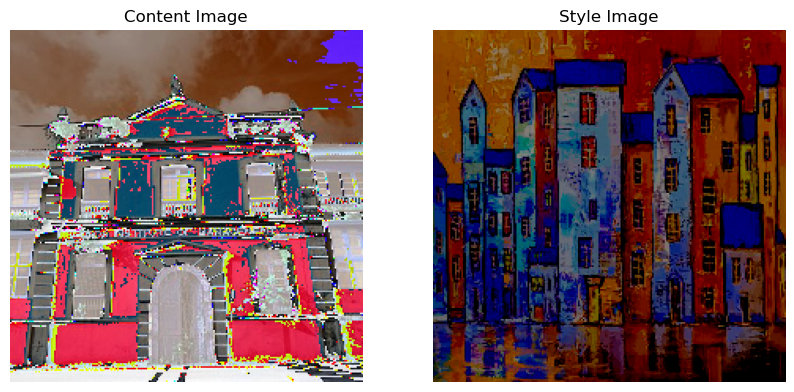

Iteration: 0
Total loss: 4.1110e+09, style loss: 4.1106e+09, content loss: 0.0000e+00, time: 3.5244s
Total time: 642.4456s


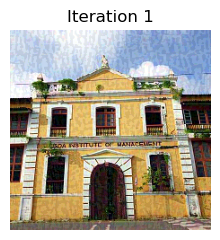

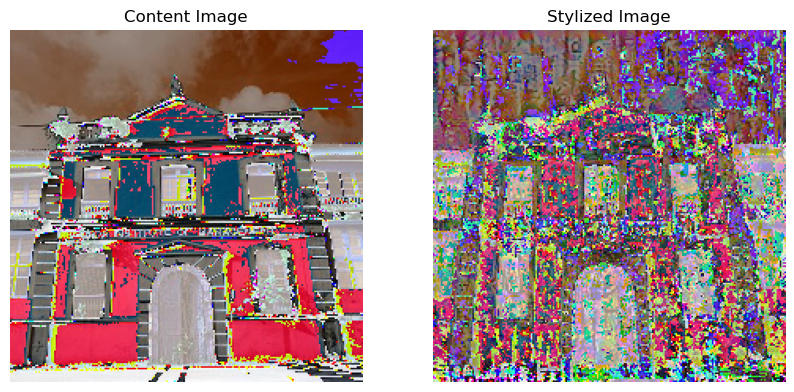

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras import backend as K
from PIL import Image

# Enable eager execution
#tf.enable_eager_execution()
#print("Eager execution: {}".format(tf.executing_eagerly()))

# Function to load and preprocess images
def load_and_process_img(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

# Function to display images
def imshow(img, title=None):
    img = np.clip(img, 0, 255).astype('uint8')
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Function to deprocess images
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                               "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
    
    # Perform the inverse of the preprocessiung step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Load content and style images
content_path = "C:/Users/Sai/Desktop/DL_Project/gim.jpg"
style_path = "C:/Users/Sai/Desktop/DL_Project/buildings_painting.jpg"

# Display content and style images
plt.figure(figsize=(10, 10))
content = load_and_process_img(content_path).astype('uint8')
style = load_and_process_img(style_path)

plt.subplot(1, 2, 1)
imshow(content[0], 'Content Image')

plt.subplot(1, 2, 2)
imshow(style[0], 'Style Image')
plt.show()

# Define content and style layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Function to get the VGG19 model with access to intermediate layers
def get_model():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs

    return models.Model(vgg.input, model_outputs)

# Function to compute content loss
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Function to compute gram matrix
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

# Function to compute style loss
def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

def total_variation_loss(x):
    img_nrows, img_ncols = x.shape[1], x.shape[2]
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    
    # Ensure shapes are compatible
    a = a[:, :img_nrows - 1, :img_ncols - 1, :]
    b = b[:, :img_nrows - 1, :img_ncols - 1, :]
    
    return K.sum(K.pow(a + b, 1.25))


# Function to get style and content features from the model
def get_feature_representations(model, content_path, style_path):
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    
    stack_images = np.concatenate([style_image, content_image], axis=0)
    model_outputs = model(stack_images)

    style_features = [style_layer[0] for style_layer in model_outputs[:num_style_layers]]
    content_features = [content_layer[1] for content_layer in model_outputs[num_style_layers:]]
    
    return style_features, content_features

# Function to compute total loss
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight, total_variation_weight = loss_weights
    
    model_outputs = model(init_image)
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)
    
    style_score *= style_weight
    content_score *= content_weight
    total_variation_score = total_variation_weight * total_variation_loss(init_image)

    loss = style_score + content_score + total_variation_score 
    return loss, style_score, content_score, total_variation_score

# Function to compute gradients
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

# Function to run style transfer
def run_style_transfer(content_path, style_path, num_iterations=500, content_weight=1e3, style_weight=1e-2):
    display_num = 100
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
    
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    
    opt = tf.keras.optimizers.Adam(learning_rate=10.0)
    
    iter_count = 1
    best_loss, best_img = float('inf'), None
    
    loss_weights = (style_weight, content_weight, 1e-4)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }
    
    plt.figure(figsize=(15, 15))
    #num_rows = (num_iterations // display_num) // 5
    num_rows = max(1, (num_iterations // display_num) // 5)

    start_time = time.time
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255.0 - norm_means

    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score, _ = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)

        end_time = time.time()

        if loss < best_loss:
            best_loss = loss
            best_img = init_image.numpy()

        if i % display_num == 0:
            print('Iteration: {}'.format(i))
            print('Total loss: {:.4e}, '
                  'style loss: {:.4e}, '
                  'content loss: {:.4e}, '
                  'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
            start_time = time.time()

            # Display intermediate images
            plt.subplot(num_rows, 5, iter_count)
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            plt.imshow(plot_img)
            plt.title('Iteration {}'.format(i + 1))
            plt.axis('off')

            iter_count += 1

    print('Total time: {:.4f}s'.format(time.time() - global_start))
   
    
    # Display the final stylized image
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    imshow(content[0], 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(tf.cast(best_img[0], tf.uint8), 'Stylized Image')  # Update this line

    plt.show()
    
    final_stylized_path = "C:/Users/Sai/Desktop/DL_Project/final_stylized_image_gim.jpg"
    final_stylized_img = deprocess_img(best_img)
    final_stylized_img = Image.fromarray(final_stylized_img)
    final_stylized_img.save(final_stylized_path)

    return best_img, best_loss

# Run style transfer
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=500, content_weight=1e3, style_weight=1e-2)
